In [1]:
import time
import numpy as np
from numba import typed
from pyloki.simulation.pulse import PulseSignalConfig
from pyloki.config import PulsarSearchConfig
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import Periodogram
from pyloki.detection import scoring, thresholding
from pyloki.utils import np_utils
from pyloki.prune import Pruning
from matplotlib import pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


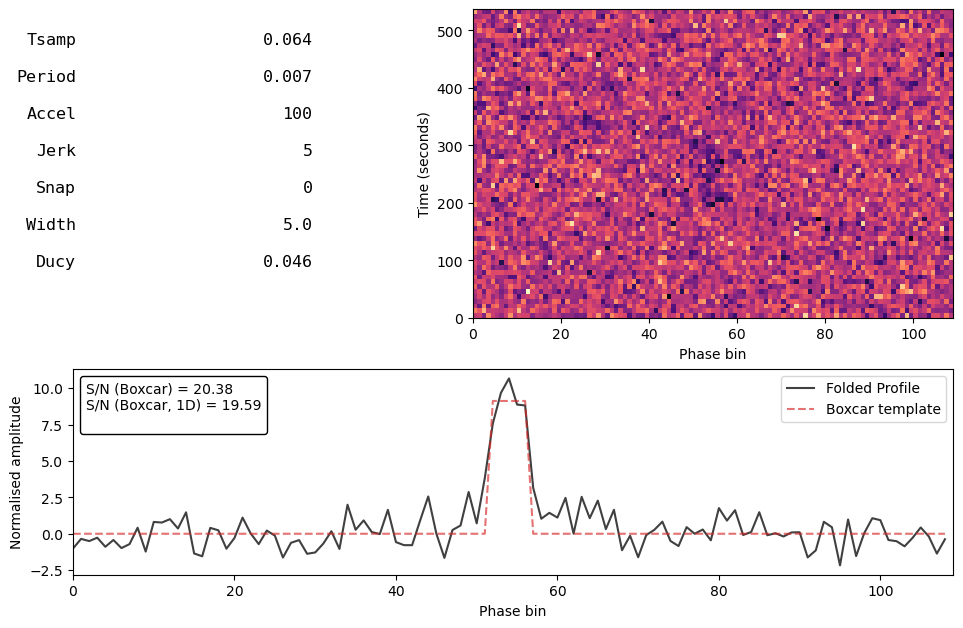

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 100
jerk = 5
nsamps = 2**23
mod_kwargs = {"acc": accel, "jerk": jerk}

cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=20, ducy=0.1, mod_kwargs=mod_kwargs)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs); plt.show()

In [3]:
tol_bins = cfg.tol_bins
fold_bins = cfg.fold_bins

tol_bins = 4
fold_bins = cfg.fold_bins
param_limits = typed.List([(0.0, 10.0), (-1500.0, 1500.0), (1/0.0075, 1/0.0065)])
bseg_brute = cfg.nsamps // 2048
bseg_ffa = cfg.nsamps // 64
search_cfg = PulsarSearchConfig(cfg.nsamps, cfg.dt, fold_bins, tol_bins, param_limits, bseg_brute=bseg_brute, bseg_ffa=bseg_ffa, prune_poly_order=3)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

2024-09-11 01:18:53 INFO     - pyloki.ffa - Initializing data structure...

                    INFO     - pyloki.ffa - param steps: [2.04494739e+08 8.93451148e+06 1.43548246e-01]

2024-09-11 01:18:55 INFO     - pyloki.ffa - fold dimensions: (2048, 1, 1, 142, 2, 109)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 2.440 seconds

                    INFO     - pyloki.ffa - param steps: [2.55618424e+07 2.23362787e+06 7.08731135e-02]

2024-09-11 01:18:57 INFO     - pyloki.ffa - i_iter: 1, fold dims: (1024, 1, 1, 289, 2, 109)

                    INFO     - pyloki.ffa - param steps: [3.19523030e+06 5.58406968e+05 3.52155195e-02]

                    INFO     - pyloki.ffa - i_iter: 2, fold dims: (512, 1, 1, 582, 2, 109)

                    INFO     - pyloki.ffa - param steps: [3.99403787e+05 1.39601742e+05 1.75530159e-02]

                    INFO     - pyloki.ffa - i_iter: 3, fold dims: (256, 1, 1, 1168, 2, 109)

                    INFO     - pyloki.ffa - param steps: [4.99254734e+04 3.49004355e+04 8.76288568e-03]

                    INFO     - pyloki.ffa - i_iter: 4, fold dims: (128, 1, 1, 2340, 2, 109)

                    INFO     - pyloki.ffa - param steps: [6.24068418e+03 8.72510887e+03 4.37804520e-03]

                    INFO     - pyloki.ffa - i_iter: 5, fold dims: (64, 1, 1, 4685, 2, 109)

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 1.940 seconds

In [4]:
target_snr = 10
thresholds = thresholding.bound_scheme(dyp.nsegments, target_snr)
prn = Pruning(dyp, thresholds, max_sugg=2**19)
res = prn.execute(snr_lim=10)

2024-09-11 01:18:58 INFO     - pyloki.prune - Initializing pruning with ref segment: 0

2024-09-11 01:19:00 INFO     - pyloki.prune - prune_initialize finished, Elapsed time: 2.781 seconds

Output()

In [5]:
from pyloki.utils.misc import C_VAL
delta_t = (prn.scheme.ref - prn.scheme.get_coord(prn.prune_level)[0]) * prn.dyp.tseg
jerk_prune_ref = cfg.mod_kwargs["jerk"]
acc_prune_ref = cfg.mod_kwargs["acc"] + cfg.mod_kwargs["jerk"] * delta_t
vel_prune_ref = cfg.mod_kwargs["acc"] * delta_t + 0.5 * cfg.mod_kwargs["jerk"] * delta_t**2
freq_prune_ref = cfg.freq * (1 + vel_prune_ref / C_VAL)
print(f"True params, j: {jerk_prune_ref:.3f}, a: {acc_prune_ref:.3f}, f: {freq_prune_ref:.10f}")

nresults = 10
res_inds = np.argsort(prn.suggestion.scores)[-nresults:][::-1]
print(f"dj: {prn.suggestion.param_sets[0][0,1]}, da: {prn.suggestion.param_sets[0][1,1]}, dp: {prn.suggestion.param_sets[0][2,1]},")
for idx in res_inds:
    param = prn.suggestion.param_sets[idx]
    snr = prn.suggestion.scores[idx]
    print(f"idx: {idx}, j: {param[0,0]:.3f}, a: {param[1,0]:.3f}, p: {param[2,0]:.10f}, S/N: {snr:.3f}")

True params, j: 5.000, a: -1221.206, f: 142.9277318581
dj: 0.0411522633744856, da: 3.0864197530864192, dp: 5.4049940757149025e-05,
idx: 792, j: 5.000, a: -1226.852, p: 142.9284754959, S/N: 15.219
idx: 586, j: 5.000, a: -1217.593, p: 142.9273944971, S/N: 14.959
idx: 851, j: 5.000, a: -1226.852, p: 142.9286376458, S/N: 14.874
idx: 587, j: 5.000, a: -1217.593, p: 142.9274485471, S/N: 14.866
idx: 952, j: 5.041, a: -1239.198, p: 142.9294483949, S/N: 14.852
idx: 384, j: 4.959, a: -1205.247, p: 142.9264762242, S/N: 14.742
idx: 1127, j: 5.041, a: -1239.198, p: 142.9295564948, S/N: 14.729
idx: 552, j: 5.000, a: -1217.593, p: 142.9272323473, S/N: 14.636
idx: 1126, j: 5.041, a: -1239.198, p: 142.9295024448, S/N: 14.531
idx: 554, j: 5.000, a: -1217.593, p: 142.9273404472, S/N: 14.496


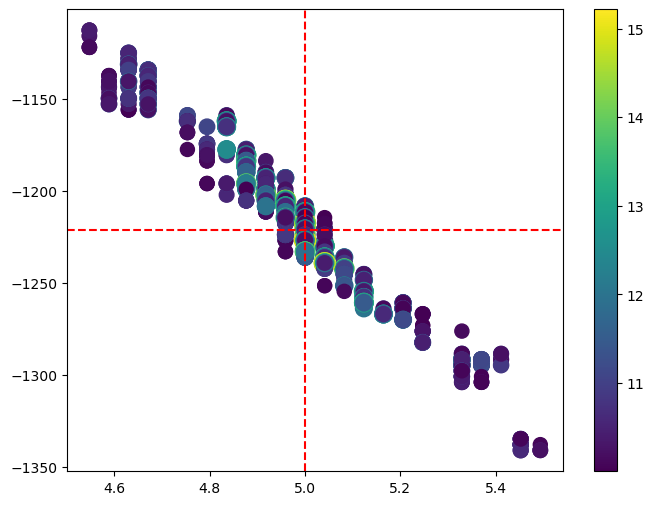

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.scatter(prn.suggestion.param_sets[:, :, 0][:, 0], prn.suggestion.param_sets[:, :, 0][:, 1], 
                c=prn.suggestion.scores, s=prn.suggestion.scores**2)
ax.axhline(acc_prune_ref, c="r", ls="--")
ax.axvline(jerk_prune_ref, c="r", ls="--")
plt.colorbar(im, ax=ax)
plt.show()

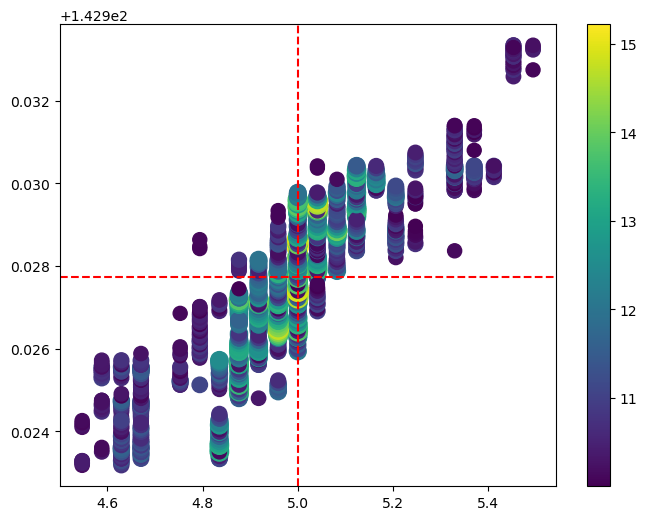

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.scatter(prn.suggestion.param_sets[:, :, 0][:, 0], prn.suggestion.param_sets[:, :, 0][:, 2],
                c=prn.suggestion.scores, s=prn.suggestion.scores**2)
ax.axvline(jerk_prune_ref, c="r", ls="--")
ax.axhline(freq_prune_ref, c="r", ls="--")
plt.colorbar(im, ax=ax)
plt.show()

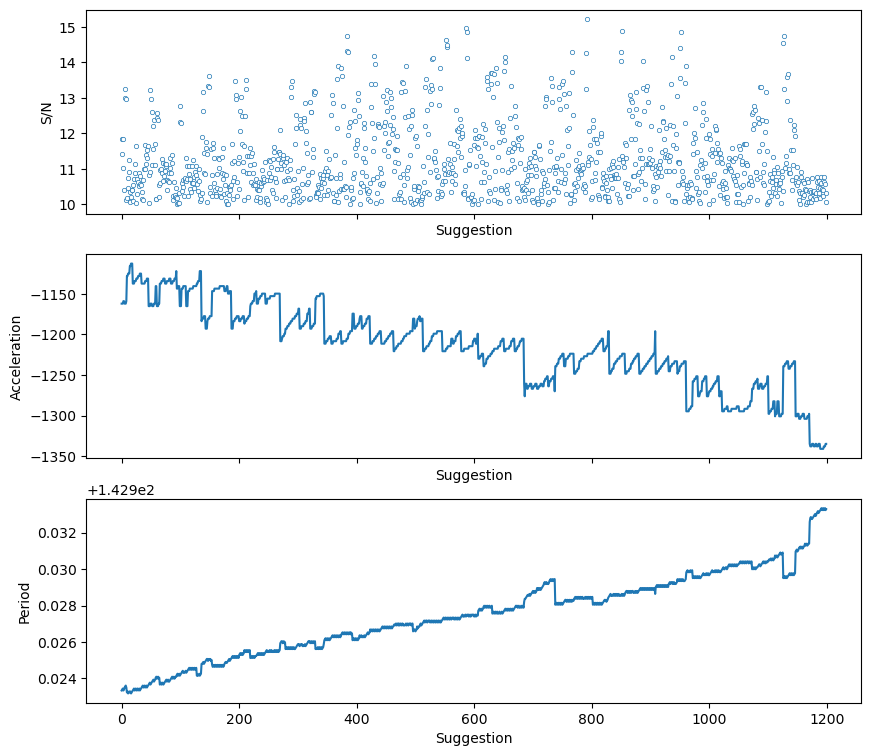

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 9), dpi=100)
ax1.scatter(np.arange(prn.suggestion.size), prn.suggestion.scores, s=10, edgecolor="tab:blue", facecolor="white",linewidth=0.5)
ax1.set_xlabel("Suggestion")
ax1.set_ylabel("S/N")
ax2.plot(np.arange(prn.suggestion.size), prn.suggestion.param_sets[:, :, 0][:,1])
ax2.set_xlabel("Suggestion")
ax2.set_ylabel("Acceleration")
ax3.plot(np.arange(prn.suggestion.size), prn.suggestion.param_sets[:, :, 0][:,2])
ax3.set_xlabel("Suggestion")
ax3.set_ylabel("Period")
plt.show()